# Mole detection

In [ ]:
import os

from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16, mobilenet_v2

from cv2 import bilateralFilter

If yourun this notebook from Google Colab, make sure to have the correct labeled dataset at the root of your Google Drive

In [ ]:
try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


IndexError: list index out of range

In [5]:
if IN_COLAB:
    drive.mount('/content/drive/')
    base_path = '/content/drive/MyDrive'
else:
    base_path = '.'

In [6]:
# paths definition
dataset_path = os.path.join(base_path, 'labeled_dataset')
train_path = os.path.join(dataset_path, 'train')
valid_path = os.path.join(dataset_path, 'valid')
test_path = os.path.join(dataset_path, 'test')

In [7]:
# model constants definition
CLASSES = ['malignant', 'benign']
INPUT_SIZE = (224, 224)
# INPUT_SIZE = (387, 632)
INPUT_SHAPE = INPUT_SIZE + (3,)
BATCH_SIZE = 32
EPOCHS = 20

In [15]:
#function for image preprocessing
#from skimage import exposure
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from cv2 import bilateralFilter
#rom numpy import uint8

D = 9
SIGMACOLOR = 75
SIGMASPACE = 75 #sigmaSpace[, borderType]]

def preprocess_vgg16(image):
  image = bilateralFilter(image, d=D, sigmaColor=SIGMACOLOR, sigmaSpace=SIGMASPACE)
  image = vgg16_preprocess(image, data_format=None)
  return image

def preprocess_mobilenet(image):
  image = bilateralFilter(image, d=D, sigmaColor=SIGMACOLOR, sigmaSpace=SIGMASPACE)
  image = mobilenet_preprocess(image, data_format=None)
  return image

In [19]:
train_batches = ImageDataGenerator(
    preprocessing_function=preprocess_vgg16).flow_from_directory(
        train_path, 
        target_size=INPUT_SIZE, 
        classes=CLASSES, 
        shuffle = True,
        batch_size=BATCH_SIZE)
valid_batches = ImageDataGenerator(
    preprocessing_function=preprocess_vgg16).flow_from_directory(
        valid_path, 
        target_size=INPUT_SIZE, 
        classes=CLASSES, 
        shuffle = True,
        batch_size=BATCH_SIZE)
test_batches = ImageDataGenerator(
    preprocessing_function=preprocess_vgg16).flow_from_directory(
        test_path, 
        target_size=INPUT_SIZE, 
        classes=CLASSES, 
        shuffle = False,
        batch_size=BATCH_SIZE)

Found 2177 images belonging to 2 classes.
Found 434 images belonging to 2 classes.
Found 289 images belonging to 2 classes.


In [17]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')



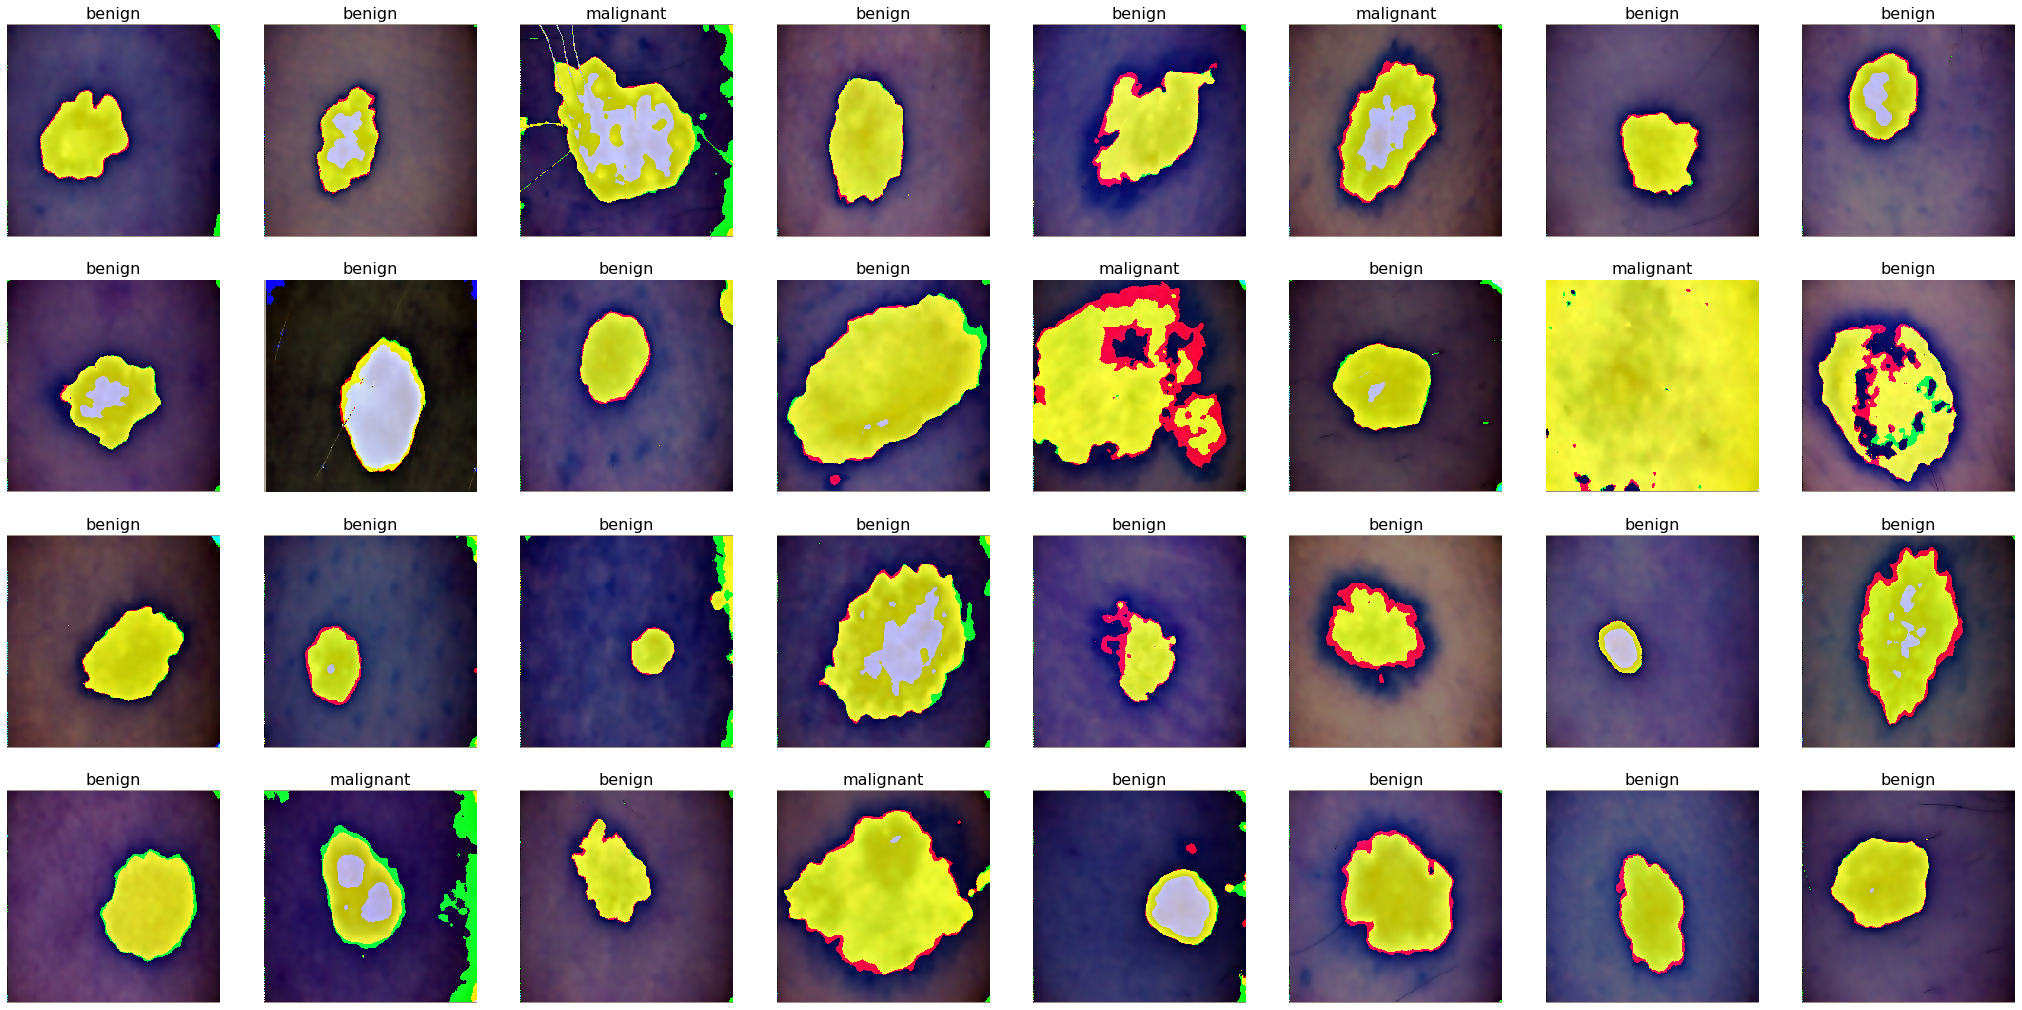

In [20]:
class_dict = train_batches.class_indices
imgs, labels = next(train_batches)
titles = ['benign' if x[class_dict['benign']]==1 else 'malignant' for x in labels]
plots(imgs, figsize=(36,18), titles=titles, rows=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


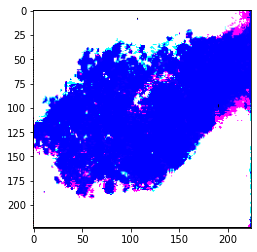

In [39]:
# imgs[0]
# plt.imshow(imgs[0])

In [21]:
model = Sequential()
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
model.add(base_model)
model.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 21,137,986
Non-trainable params: 0
_________________________________________________________________


In [23]:
for layers in model.layers[0].layers: # looping over each layers in layer 0 to freeze them
  layers.trainable = False

model.layers[0].trainable = False

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 6,423,298
Non-trainable params: 14,714,688
_________________________________________________________________


In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_batches, 
          steps_per_epoch=len(train_batches.filenames)//BATCH_SIZE, 
          epochs=EPOCHS, 
          validation_data=valid_batches, 
          validation_steps=len(test_batches.filenames)//BATCH_SIZE
          )
          

Epoch 1/20
39/68 [================>.............] - ETA: 4:56 - loss: 12.5325 - accuracy: 0.6767 

In [ ]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

In [ ]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
train_batches = ImageDataGenerator(
    preprocessing_function=preprocess_mobilenet).flow_from_directory(
        train_path, 
        target_size=INPUT_SIZE, 
        classes=CLASSES, 
        shuffle = True,
        batch_size=BATCH_SIZE)
valid_batches = ImageDataGenerator(
    preprocessing_function=preprocess_mobilenet).flow_from_directory(
        valid_path, 
        target_size=INPUT_SIZE, 
        classes=CLASSES,
        shuffle = True,
        batch_size=BATCH_SIZE)
test_batches = ImageDataGenerator(
    preprocessing_function=preprocess_mobilenet).flow_from_directory(
        test_path, 
        target_size=INPUT_SIZE, 
        classes=CLASSES, 
        shuffle = False,
        batch_size=BATCH_SIZE)

In [ ]:
model = Sequential()
base_model = mobilenet_v2.MobileNetV2(weights='imagenet',include_top=False, input_shape=INPUT_SHAPE)
model.add(base_model)
model.layers[0].summary()

In [ ]:
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))
model.summary()

In [ ]:
for layers in model.layers[0].layers: # looping over each layers in layer 0 to freeze them
  layers.trainable = False

model.layers[0].trainable = False

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_batches, 
          steps_per_epoch=len(train_batches.filenames)//BATCH_SIZE, 
          epochs=EPOCHS*2, 
          validation_data=valid_batches, 
          validation_steps=len(test_batches.filenames)//BATCH_SIZE
          )

In [ ]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

In [ ]:
epochs_range = range(EPOCHS*2)

plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('temp_model.h5')